In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data importation and cleaning

In [14]:
new_column_names = {"ID_PACIENTE" : "Patient ID", "SEXO" : "Sex", "EDAD_A_OS" : "Age", "PREVISION" : "Health insurance",
                    "PERTENENCIA_ESTABLECIMIENTO_SALUD" : "Healthcare facility type",
                    "GLOSA_ESTABLECIMIENTO_SALUD" : "Healthcare facility name", "DIAS_ESTADA" : "Length of stay",
                    "CONDICION_EGRESO" : "Discharge condition", "DIAG1" : "Primary diagnosis code", "GLOSA_DIAG1" : "Primary diagnosis name",
                    "Año" : "Year"}

new_dtypes = {"Sex": "category", "Patient ID": "category", "Health insurance": "category", "Healthcare facility type": "category",
              "Length of stay": "int32", "Discharge condition": "category", "Age": "int32"}


In [16]:
# CSV file is lighter (4gb) than a Parquet (6gb) and helps to make the analysis faster.
# But as still the file is too heavy, I will load in chunks and change column names and data types in some columns

csv_file = "Egresos_2001-2020.csv"
chunk_size = 500_000  
chunks = []

for chunk in pd.read_csv(csv_file, chunksize=chunk_size, low_memory=False):
    # Rename columns
    chunk = chunk.rename(columns=new_column_names)
    
    # Convert data types
    chunk = chunk.astype(new_dtypes, errors="ignore")  
    
    chunks.append(chunk)

# Merge all chunks
df_final = pd.concat(chunks, ignore_index=True)

# Save as optimized Parquet
df_final.to_parquet("Egresos_cleaned.parquet", engine="pyarrow", compression="snappy")


Basic information about the data

In [3]:
df_final = pd.read_parquet("Egresos_cleaned.parquet")

In [5]:
# A quick view of the data
df_final.head()

,Patient ID,Sex,Age,Health insurance,Healthcare facility type,Healthcare facility name,Length of stay,Discharge condition,Primary diagnosis code,Primary diagnosis name,Year
0,None,Hombre,60,Fonasa,Privado,Clínica Familia,2,Muerto,C780,TUMOR MALIGNO SECUNDARIO DEL PULMÓN,2001
1,None,Hombre,74,Fonasa,Publico,"Hospital Del Salvador (Santiago, Providencia)",58,Muerto,E145,"DIABETES MELLITUS NO ESPECIFICADA, CON COMPLIC...",2001
2,None,Hombre,71,Fonasa,Publico,"Hospital Del Salvador (Santiago, Providencia)",12,Muerto,J189,"NEUMONIA, NO ESPECIFICADA",2001
3,None,Hombre,2,Fonasa,Publico,Instituto de Neurocirugía Dr. Alfonso Asenjo,1,Muerto,S065,HEMORRAGIA SUBDURAL TRAUMÁTICA,2001
4,None,Hombre,81,Fonasa,Publico,Hospital Dr. Leonardo Guzmán (Antofagasta),7,Vivo,K830,COLANGITIS,2001


In [7]:
# the datatype of each column was established in the notebook "Data_Importation"
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26340655 entries, 0 to 26340654
Data columns (total 11 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   Patient ID                object  
 1   Sex                       object  
 2   Age                       int32   
 3   Health insurance          category
 4   Healthcare facility type  category
 5   Healthcare facility name  object  
 6   Length of stay            int32   
 7   Discharge condition       category
 8   Primary diagnosis code    object  
 9   Primary diagnosis name    object  
 10  Year                      int64   
dtypes: category(3), int32(2), int64(1), object(5)
memory usage: 1.4+ GB


Missing data in "ID_PACIENTE" column

In [9]:
# All missing data was deleted on the importation process, except on "GLOSA_ESTABLECIMIENTO_SALUD" and "ID_PACIENTE" columns
df_final.isnull().sum()

Patient ID                  1944331
Sex                               0
Age                               0
Health insurance                  0
Healthcare facility type          0
Healthcare facility name       2753
Length of stay                    0
Discharge condition               0
Primary diagnosis code            0
Primary diagnosis name            0
Year                              0
dtype: int64

In [11]:
df_final.shape

(26340655, 11)

# Exploring "ID_Patient" column

Null IDs:
If missing IDs correlate with missing key data → Drop those rows.
If missing IDs appear in specific hospitals → Check their policies.
If missing IDs are mostly from deceased patients → It might be a reporting issue.
If missing IDs follow a pattern over time → Investigate policy changes.
If missing IDs belong to frequent diagnoses → Maybe these visits don’t require ID.

In [14]:
# The percentage of null values is 7% and is too high to delete all those rows, because a large amount of valuable data could be lost
df_final['Patient ID'].isna().mean()

0.07381483110423792

In [4]:
# Groupby to understand if there is a pattern associated to the missing data in the column
df_nanID = df_final.loc[df_final['Patient ID'].isnull()]

<Axes: xlabel='Age'>

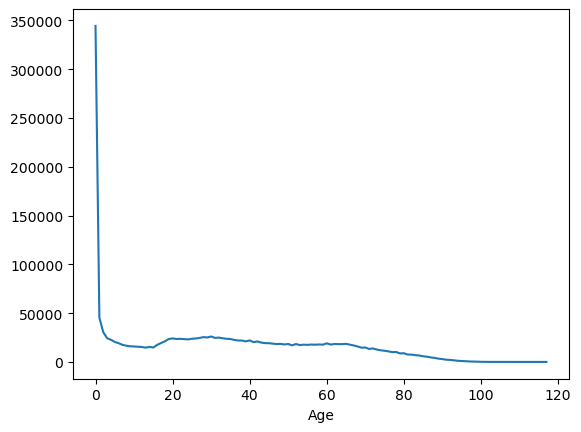

In [36]:
df_nanID.groupby(['Age'], sort = True).size().plot.line()
# There are not more NaN values in certain age apart of newborns who are the majority

In [64]:
# Identify If Certain Hospitals Have More Missing IDs
df_nanID.groupby(['Healthcare facility name']).size().to_frame('size').sort_values(['size'],ascending=False).head(10)
# Research about policies in Hospital Clinico Universidad catolica

,size
Healthcare facility name,
Hospital Clínico Universidad Católica,255693
Hospital Clínico Regional Dr. Guillermo Grant Benavente (Concepción),76542
Hospital Dr. Juan Noé Crevanni (Arica),71319
"Hospital San Juan de Dios (Santiago, Santiago)",70280
Complejo Asistencial Dr. Víctor Ríos Ruiz (Los Ángeles),58896
Clínica Dávila,48652
Hospital Dr. Hernán Henríquez Aravena (Temuco),41478
Clínica Iquique,35365
Hospital Dr. Leonardo Guzmán (Antofagasta),34095


# lenght of stay (VER COMO MANEJAR OUTLIERS ANTES DE ANALIZAR NAN IDS)

In [55]:
df_nanID['Length of stay'].unique()

array([    2,    58,    12,     1,     7,     3,    14,     5,    45,
          19,     6,   105,    83,    55,    13,    24,    15,    74,
          65,     4,     9,    82,    27,    10,    26,    30,    37,
          16,    35,     8,    20,   102,    25,   796,    11,    17,
          18,    64,    34,    39,    78,    22,    21,    66,    29,
          36,    40,    46,    61,    69,    97,    33,    42,    43,
          41,    72,    70,    28,   129,    44,    49,   137,    75,
          84,    89,   119,    23,    52,   197,    50,    63,    85,
          54,    31,    59,    32,    53,    51,    48,    60,    76,
          90,    86,   109,  3849,    67,    68,   262,    57,   104,
         163,   185,    56,   134,    81,    38,   110,    80,   115,
          73,   152,    71,    91,   297,   228,    79,    62,   103,
         153,   182,   181,    47,   122,   125,    95,    77,   116,
         140,   108,   114,   168,   179,   189,   118,    87,   507,
         202,   333,

<Axes: xlabel='Length of stay'>

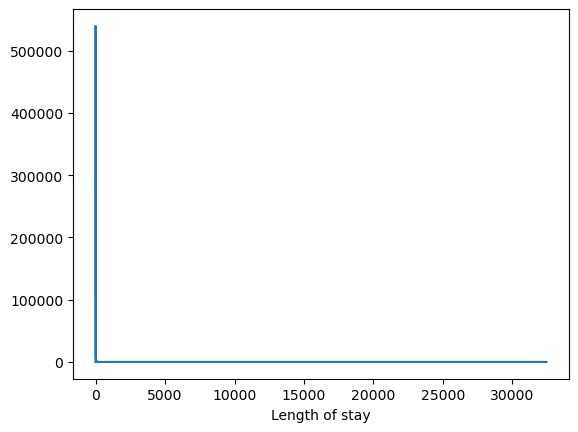

In [51]:
# Analyze by lenght of stay
df_nanID.groupby(['Length of stay'], sort = True).size().plot.line()

In [47]:
# Analyze by patient health insurance
df_nanID.groupby(['Health insurance']).size()

C:\Users\mirko\AppData\Local\Temp\ipykernel_13752\3554200689.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_nanID.groupby(['Health insurance']).size()


Health insurance
Fonasa    1502248
Isapre     442083
dtype: int64

In [66]:
# Analyze by Patient Condition (CONDICION_EGRESO)
df_nanID.groupby(['Discharge condition']).size()

C:\Users\mirko\AppData\Local\Temp\ipykernel_18680\999373616.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_nanID.groupby(['Discharge condition']).size()


Discharge condition
Muerto      37246
Vivo      1907085
dtype: int64

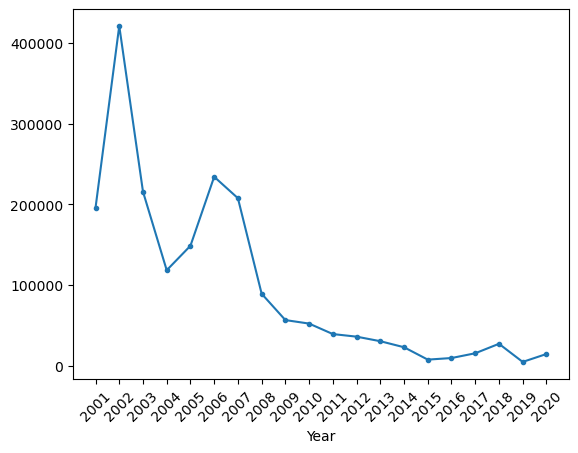

In [39]:
# Check Trends Over Time
plt.figure()
df_nanID.groupby(['Year'], sort = True).size().plot.line(style='.-')
plt.xticks(list(df_final["Year"].unique()), rotation = 45)
plt.show()

In [41]:
# Compare with Gender
df_nanID.groupby(['Sex']).size()

Sex
Hombre    981351
Mujer     962980
dtype: int64

# Diagnosis

In [7]:
# Count valid and nan ID values for each diagnosis
counts_nan = df_nanID["Primary diagnosis name"].value_counts()
counts_values = df_final["Primary diagnosis name"].value_counts()

In [8]:
# Convert the value counts output series to a dataframe
counts_df = counts_values.rename_axis('Primary diagnosis name').reset_index(name='Frequency of values')
counts_nanvals = counts_nan.rename_axis('Primary diagnosis name').reset_index(name='Frequency of nan')

In [10]:
# Create a dataframe object to save the percent of nan values for each diagnosis out of the total for each of them
nanID_disease = pd.DataFrame(counts_nan/counts_values*100).reset_index().sort_values(by='count', ascending=False)

In [13]:
# Merge the 3 dataframes to have the count of people (IDs) for each diangosis, the nan values and the percent of nan values out of the total cases for each diagnosis
df_diseases = nanID_disease.merge(counts_df, on='Primary diagnosis name', how='left')
df_diseases = df_diseases.merge(counts_nanvals, on='Primary diagnosis name', how='left')
df_diseases = df_diseases.rename(columns={"count": "Percent of nan"})

In [15]:
# This shows that when there are not NaN IDs the percent is NaN and should be 0%. Lets replace that value
df_diseases.isnull().sum()

Primary diagnosis name       0
Percent of nan            1874
Frequency of values          0
Frequency of nan          1874
dtype: int64

In [17]:
# NaN values in percent mean that is 0%
df_diseases['Percent of nan'] = df_diseases['Percent of nan'].fillna(0)

In [19]:
# Diagnosis with only nan IDs: This shows that very rare diagnosis have 100% of NaN Patient IDs with maximun 4 IDs. 
df_diseases[df_diseases['Percent of nan'] == 100].sort_values(by='Frequency of values', ascending=False).head(5)

,Primary diagnosis name,Percent of nan,Frequency of values,Frequency of nan
5,"DISFUNCION HIPOTALAMICA, NO CLASIFICADA EN OTR...",100.0,4,4.0
28,PRESENCIA DE VALVULA CARDIACA PROTESICA,100.0,4,4.0
15,TUMOR MALIGNO DEL CLITORIS,100.0,3,3.0
30,PALUDISMO CONGENITO POR PLASMODIUM FALCIPARUM,100.0,3,3.0
39,CONSULTA PARA ATENCION Y SUPERVISION DE LA SAL...,100.0,2,2.0


In [21]:
# About the frequency of NaN Patient IDs, it is higher for births and other common or prevalent diseases, as expected
df_diseases[df_diseases['Percent of nan'] != 100].sort_values(by='Frequency of values', ascending=False).head(10)

,Primary diagnosis name,Percent of nan,Frequency of values,Frequency of nan
5695,"PARTO UNICO ESPONTANEO, SIN OTRA ESPECIFICACION",5.845318,965713,56449.0
6038,"PARTO UNICO ESPONTANEO, PRESENTACION CEFALICA ...",5.409004,693270,37499.0
7581,"PARTO POR CESAREA, SIN OTRA ESPECIFICACION",3.399915,608280,20681.0
4958,"NEUMONIA, NO ESPECIFICADA",6.761687,578332,39105.0
6587,CALCULO DE LA VESICULA BILIAR SIN COLECISTITIS,4.715302,440396,20766.0
7785,PARTO POR CESAREA ELECTIVA,3.039879,366429,11139.0
8631,OTRAS APENDICITIS AGUDAS Y LAS NO ESPECIFICADAS,1.048422,290341,3044.0
4944,"HERNIA INGUINAL UNILATERAL O NO ESPECIFICADA, ...",6.788624,268891,18254.0
1905,APENDICITIS AGUDA NO ESPECIFICADA,13.938155,254345,35451.0
6183,"INFECCION DE VÍAS URINARIAS, SITIO NO ESPECIFI...",5.243365,222033,11642.0


In [23]:
# Lets check the diagnosis with high percent of NaN IDs that also are the most frequent among that group

In [25]:
# The table shows that only births are diagnosis with a high percent of NaN IDs AND high amount or frequency of IDs.

# If df_norm is a slice, make a real copy
df_norm = df_diseases[df_diseases['Percent of nan'] != 100].copy()

# Normalize 'Percent of nan' (assuming it's between 0 and 100)
df_norm['percent_norm'] = df_norm['Percent of nan'] / 100

# Normalize 'Frequency of values'
df_norm['count_norm'] = (
    (df_norm['Frequency of values'] - df_norm['Frequency of values'].min()) /
    (df_norm['Frequency of values'].max() - df_norm['Frequency of values'].min())
)

# Create a combined score
df_norm['score'] = df_norm['percent_norm'] + df_norm['count_norm']

# Sort by score descending
df_sorted = df_norm.sort_values(by='score', ascending=False)

# Makes diagnosis names shorter to display
df_sorted['Primary diagnosis name'] = df_sorted['Primary diagnosis name'].str.slice(0, 25)


# Show the top 10 disgnosis with the higher percent of NaN patient IDs and higher amount of IDs with that diagnosis
print(df_sorted[['Primary diagnosis name', 'Percent of nan', 'Frequency of values', 'score']].head(10))


         Primary diagnosis name  Percent of nan  Frequency of values     score
5695  PARTO UNICO ESPONTANEO, S        5.845318               965713  1.058453
41    FETO Y RECIEN NACIDO AFEC       90.909091                   11  0.909101
42    FETO Y RECIEN NACIDO AFEC       90.048251                 1658  0.902198
44    FETO Y RECIEN NACIDO AFEC       88.714003                14168  0.901810
43       OTRAS TERAPIAS FISICAS       89.912281                  228  0.899358
45    OTRAS INFECCIONES VIRALES       88.095238                   42  0.880995
46    OTROS NACIMIENTOS MULTIPL       83.333333                    6  0.833339
47    OTRAS DISFUNCIONES OVARIC       80.000000                    5  0.800004
6038  PARTO UNICO ESPONTANEO, P        5.409004               693270  0.771974
49    LESION (NEOPLASICA) DE SI       76.190476                   42  0.761947


# Export data to analyze readmissions

In [43]:
mask = df_final['Patient ID'].notna() & (df_final['Year'] >= 2008)
df_revisit = df_final[mask]

In [45]:
df_revisit.to_parquet("Readmissions.parquet", engine="pyarrow", compression="snappy")

Duplicates IDs and re-hospitalizations:
If duplicates are exact copies → Drop them.
If a patient was hospitalized multiple times in a year for the same issue → Decide whether to count all visits or keep only the first one.
If duplicates exist across multiple years → It could indicate chronic conditions.
If duplicate entries have different conditions → Keep them, as they indicate separate illnesses.

In [ ]:
# Count duplicated and see top 10 most frequent

In [ ]:
# See exact duplicates (same values in every column)

In [ ]:
# Check Duplicates within the Same Year (Multiple hospitalizations for a chronic disease or many different health problems)

In [ ]:
# Duplicates across the years

In [27]:
df["ID_PACIENTE"][df["ID_PACIENTE"].duplicated(keep=False)]

0                                                NaN
1                                                NaN
2                                                NaN
3                                                NaN
4                                                NaN
                              ...                   
26340649    9F742AA5C59C96EF9B07F3EDBCF55F8DA744EE02
26340650    18C7CA0C9694DF3E3011E270C912D11B1BF2C257
26340651    18C7CA0C9694DF3E3011E270C912D11B1BF2C257
26340652    BB8EE4EAF297C191FFB91B1DADB935D6AEC58CE3
26340653    44A39983F8C088BBB8EFA4B103865EE1948CFD1A
Name: ID_PACIENTE, Length: 21314957, dtype: object

## Exploratory analysis and visualizations with matplotlib and seaborn

## Preguntas que surjan

1. ¿Cual es la tendencia en la evolución de la prevalencia de los problemas de salud a lo largo de los años?
2. dfsdf
3. dsf
4. sdf
5. sd
6. *Bonus: 

*Bonus: revisitas: Let’s say your goal is:
“Track how often and when patients are readmitted after a previous hospitalization.”

In this case, you need to group visits by patient to:

Calculate time between visits.

Identify patterns of recurrence.

Count how many times someone was admitted within a year.
   